In [13]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-10-09 16:49:35
# @Last Modified: 2023-10-09 16:49:42
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

import matplotlib.pyplot as plt
from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("/path/to/repo/experiment_analysis/dat/")

2024-05-23 18:51:18,513 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code_repo/experiment_analysis


In [4]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_no_merging_all.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2024-05-23 18:22:23,512 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2024-05-23 18:22:23,514 | DEBUG    | its_utility | load_metrics | Matched 12807 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN,NaN
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN,NaN
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN,NaN
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN,NaN
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.009846,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018,False
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.030980,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999,False
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.002582,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331,True
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.004683,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723,False


In [5]:
# TODO: make these default preprocessing steps.

# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
meta_df = meta_df.query("R_tot == R_tot")
len_before = len(meta_df)
meta_df = meta_df.query("tau_R >= 0.0")
meta_df = meta_df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

2024-05-23 18:27:35,344 | INFO     | notebook | <module> | removed 641 rows due to unexpected timescales


2024-05-23 18:28:13,015 | DEBUG    | plot_helper | fancy_violins | 3.0 median: 0.0759 quantiles: [0.0746138 0.0776098] from 500 samples of length 5222
2024-05-23 18:28:13,016 | DEBUG    | plot_helper | fancy_violins | 3.0 min: -0.00067 max: 0.44
2024-05-23 18:28:13,902 | DEBUG    | plot_helper | fancy_violins | 8.0 median: 0.0715 quantiles: [0.07031157 0.07281642] from 500 samples of length 5582
2024-05-23 18:28:13,903 | DEBUG    | plot_helper | fancy_violins | 8.0 min: -0.0031 max: 0.39
2024-05-23 18:28:14,635 | DEBUG    | plot_helper | fancy_violins | null median: 0.0609 quantiles: [0.05963728 0.06200247] from 500 samples of length 5657
2024-05-23 18:28:14,636 | DEBUG    | plot_helper | fancy_violins | null min: -0.0039 max: 0.48
2024-05-23 18:28:14,651 | DEBUG    | plot_helper | fancy_violins | plotting 1200 points for cat block


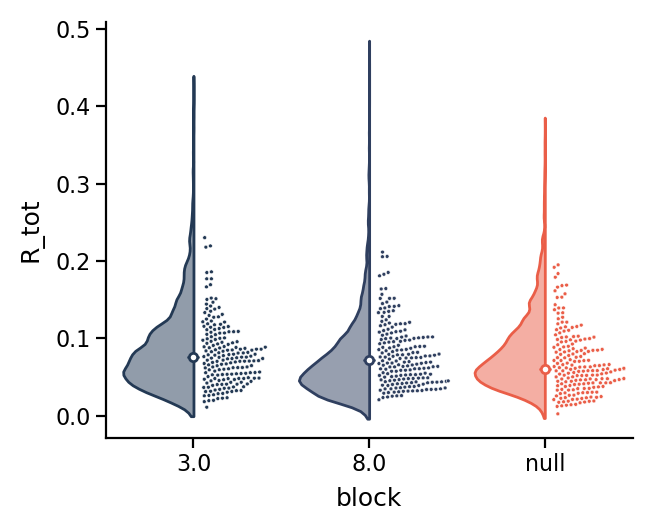

In [6]:
ph.log.setLevel("DEBUG")

df = meta_df.query(
    "((stimulus == 'natural_movie_one_more_repeats') & (block == '3.0')) | " +
    "((stimulus == 'natural_movie_one_more_repeats') & (block == '8.0')) | "
    + "((stimulus == 'spontaneous') & (block == 'null'))"
)

obs = "R_tot"

df[f"log_{obs}"] = df.apply(lambda row: np.log10(row[obs] * 1000), axis=1)

# if "tau" in obs:
#     # everything above 10s is unrealistic
#     num_dropped = len(df.query(f"({obs} > 10) | ({obs} <= 0)"))
#     log.debug(f"dropping {num_dropped} rows with too large timescales")
#     df = df.query(f"({obs} <= 1000) & ({obs} > 0.00)")

# this is a paired sample thing, only take units that have both stimuli
# fiund the intersection of units that exist in both stimuli
units = set(
    df.query("stimulus == 'spontaneous'")["unit_id"]
).intersection(set(df.query("stimulus == 'natural_movie_one_more_repeats'")["unit_id"]))
df = df.query("unit_id in @units")

ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"{obs}", # put f"log_{obs}" here for log scale
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "3.0" : "#233954",
        "8.0" : "#2F3F5F",
        "null" : "#EA5E48",
    },
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)

The predictability is also significantly smaller in the second repeated movie block compared to the first one. This could be due to adaptation effects, i.e., the code is adapted to the stimulus that becomes increasingly predictable. 

2024-05-23 18:30:25,074 | DEBUG    | plot_helper | fancy_violins | 3.0 median: 0.0704 quantiles: [0.06874913 0.07149354] from 500 samples of length 6273
2024-05-23 18:30:25,075 | DEBUG    | plot_helper | fancy_violins | 3.0 min: -0.0048 max: 0.57
2024-05-23 18:30:25,974 | DEBUG    | plot_helper | fancy_violins | 6.0 median: 0.0682 quantiles: [0.06718223 0.06945838] from 500 samples of length 6343
2024-05-23 18:30:25,975 | DEBUG    | plot_helper | fancy_violins | 6.0 min: -0.0034 max: 0.51
2024-05-23 18:30:26,815 | DEBUG    | plot_helper | fancy_violins | null median: 0.0610 quantiles: [0.05954812 0.06203764] from 500 samples of length 5695
2024-05-23 18:30:26,815 | DEBUG    | plot_helper | fancy_violins | null min: -0.0039 max: 0.48
2024-05-23 18:30:26,840 | DEBUG    | plot_helper | fancy_violins | plotting 1200 points for cat block


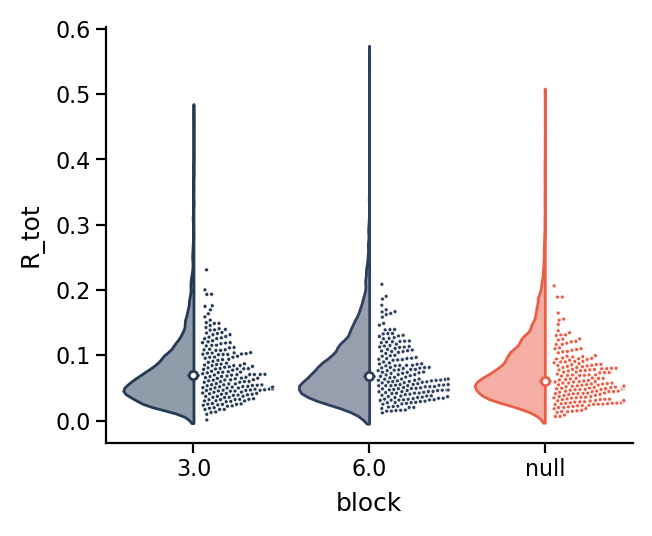

In [7]:
# For natural movie three we do not find such a strong decrease in predictability for later blocks. This could be because the stimulus is shown repeatedly
df = meta_df.query(
    "((stimulus == 'natural_movie_three') & (block == '3.0')) | " +
    "((stimulus == 'natural_movie_three') & (block == '6.0')) | "
    + "((stimulus == 'spontaneous') & (block == 'null'))"
)
# if "tau" in obs:
#     # everything above 10s is unrealistic
#     num_dropped = len(df.query(f"({obs} > 10) | ({obs} <= 0)"))
#     log.debug(f"dropping {num_dropped} rows with too large timescales")
#     df = df.query(f"({obs} <= 1000) & ({obs} > 0.00)")

ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"{obs}", # put f"log_{obs}" here for log scale
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "3.0" : "#233954",
        "6.0" : "#2F3F5F",
        "null" : "#EA5E48",
    },
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)

In [15]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2024-05-23 18:52:12,835 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2024-05-23 18:52:12,838 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN


In [16]:
# TODO: make these default preprocessing steps.

# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
meta_df = meta_df.query("R_tot == R_tot")
len_before = len(meta_df)
meta_df = meta_df.query("tau_R >= 0.0")
meta_df = meta_df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

2024-05-23 18:52:25,934 | INFO     | notebook | <module> | removed 755 rows due to unexpected timescales


2024-05-23 18:52:29,436 | DEBUG    | plot_helper | fancy_violins | merged_3.0_and_8.0 median: 0.0795 quantiles: [0.07795181 0.08079835] from 500 samples of length 5350
2024-05-23 18:52:29,437 | DEBUG    | plot_helper | fancy_violins | merged_3.0_and_8.0 min: -0.0018 max: 0.39
2024-05-23 18:52:30,427 | DEBUG    | plot_helper | fancy_violins | null median: 0.0636 quantiles: [0.06211673 0.06467466] from 500 samples of length 5495
2024-05-23 18:52:30,427 | DEBUG    | plot_helper | fancy_violins | null min: -0.002 max: 0.47
2024-05-23 18:52:30,440 | DEBUG    | plot_helper | fancy_violins | plotting 800 points for cat block
2024-05-23 18:52:31,829 | DEBUG    | plot_helper | fancy_violins | merged_3.0_and_8.0 median: 0.0530 quantiles: [0.05165953 0.05449285] from 500 samples of length 5350
2024-05-23 18:52:31,830 | DEBUG    | plot_helper | fancy_violins | merged_3.0_and_8.0 min: 0 max: 1.2
2024-05-23 18:52:32,761 | DEBUG    | plot_helper | fancy_violins | null median: 0.0538 quantiles: [0.052

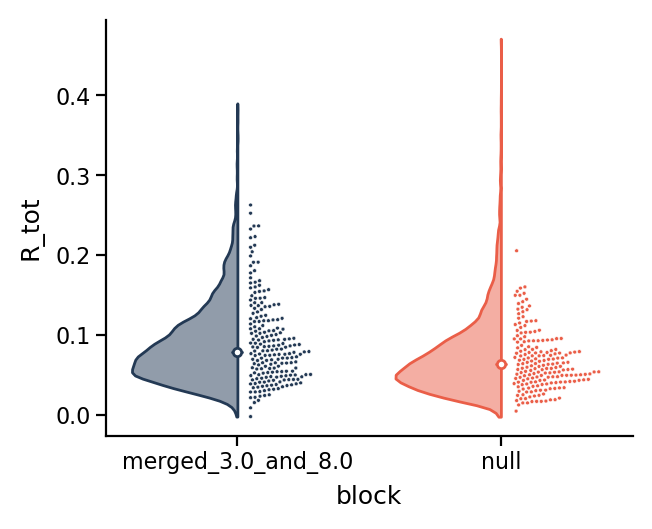

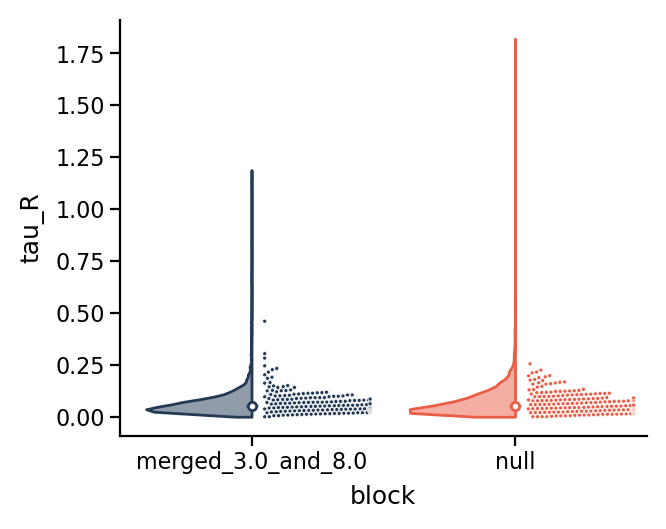

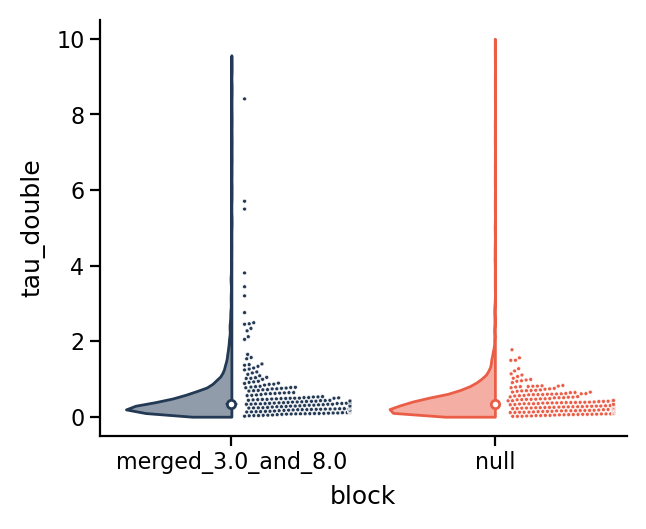

In [17]:
# For natural movie three we do not find such a strong decrease in predictability for later blocks. This could be because the stimulus is shown repeatedly
df = meta_df.query(
    "((stimulus == 'natural_movie_one_more_repeats') & (block == 'merged_3.0_and_8.0')) | "
    + "((stimulus == 'spontaneous') & (block == 'null'))"
)

obs = "R_tot"
ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"{obs}", # put f"log_{obs}" here for log scale
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "merged_3.0_and_8.0" : "#233954",
        "null" : "#EA5E48",
    },
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)

obs = "tau_R"
ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"{obs}", # put f"log_{obs}" here for log scale
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "merged_3.0_and_8.0" : "#233954",
        "null" : "#EA5E48",
    },
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)

obs = "tau_double"
ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"{obs}", # put f"log_{obs}" here for log scale
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "merged_3.0_and_8.0" : "#233954",
        "null" : "#EA5E48",
    },
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)


2024-05-23 18:57:24,347 | INFO     | notebook | <module> | r: 0.293, p: 8.9e-123, m: 0.062, b: 0.059


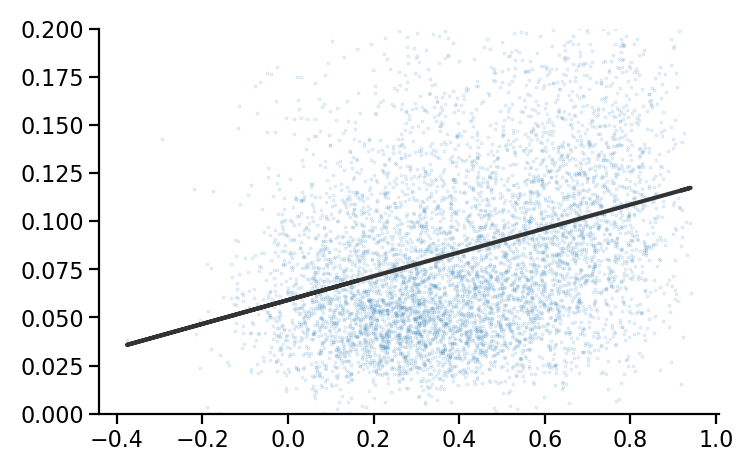

In [22]:
import scipy.stats

df = meta_df.query("stimulus == 'natural_movie_three' & block == 'merged_3.0_and_6.0'")

obs = "R_tot"
df = df.query(f"{obs} == {obs}")
df = df.query("g_dsi_dg == g_dsi_dg")
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.scatter(df["g_dsi_dg"], df[obs], s=0.1, alpha=0.2);
ax.set_ylim(0, 0.2)
# ax.set_xscale("log")

r , p_val = scipy.stats.pearsonr(df["g_dsi_dg"], df[obs])
m, b = np.polyfit(df["g_dsi_dg"], df[obs], 1)

log.info(f"r: {r:.3f}, p: {p_val:.2g}, m: {m:.3f}, b: {b:.3f}")
ax.plot(df["g_dsi_dg"], m*df["g_dsi_dg"] + b, color = ".2")


In [7]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

scipy: 1.11.1

scipy         : 1.11.1
matplotlib    : 3.7.2
pandas        : 2.0.3
xarray        : 2023.7.0
logging       : 0.5.1.2
sys           : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
sqlite3       : 2.6.0
prompt_toolkit: 3.0.39
numpy         : 1.24.4
dask          : 2023.7.1
re            : 2.2.1
IPython       : 8.14.0
h5py          : 3.9.0

